# UMAP Animated

In [1]:
from plotnine import *
import polars as pl

In [44]:
pl.Config.set_tbl_cols(10)

polars.config.Config

## Understanding handwritten digits as high-dimensional vectors

In [45]:
df_digits = pl.read_parquet("data/digits.parquet")
df_digits

pixel1,pixel2,pixel3,pixel4,pixel5,…,pixel781,pixel782,pixel783,pixel784,digit
i64,i64,i64,i64,i64,…,i64,i64,i64,i64,cat
0,0,0,0,0,…,0,0,0,0,"""5"""
0,0,0,0,0,…,0,0,0,0,"""0"""
0,0,0,0,0,…,0,0,0,0,"""4"""
0,0,0,0,0,…,0,0,0,0,"""1"""
0,0,0,0,0,…,0,0,0,0,"""9"""
…,…,…,…,…,…,…,…,…,…,…
0,0,0,0,0,…,0,0,0,0,"""8"""
0,0,0,0,0,…,0,0,0,0,"""9"""
0,0,0,0,0,…,0,0,0,0,"""6"""


## Plot digits

In [65]:
def get_pixels(df_, seed=None):
    if seed is not None:
        pl.set_random_seed(seed)
    
    return (
        df_
        .with_row_index()
        .with_columns(pl.col("index").shuffle())
        .sort("index")
        .group_by("digit").first()
        .drop("index")
        .unpivot(index=["digit"])
        .with_columns(pixel=pl.col("variable").str.strip_prefix("pixel").cast(pl.UInt16))
        .with_columns(x=(pl.col("pixel")-1) % 28,
                      y=27-(pl.col("pixel")-1) // 28)
        .drop("variable", "pixel")
    )

In [66]:
df_pixels = get_pixels(df_digits, seed=42)
df_pixels.filter(pl.col("digit") == "7")

digit,value,x,y
cat,i64,u16,u16
"""7""",0,0,27
"""7""",0,1,27
"""7""",0,2,27
"""7""",0,3,27
"""7""",0,4,27
…,…,…,…
"""7""",0,23,0
"""7""",0,24,0
"""7""",0,25,0


In [67]:
with pl.Config(tbl_rows=30, tbl_cols=30):
    display(df_pixels.filter(pl.col("digit") == "7").pivot("x", values="value"))

digit,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
cat,u16,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""7""",27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""7""",26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""7""",25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""7""",24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""7""",23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""7""",22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""7""",21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""7""",20,0,0,0,0,0,0,0,0,0,0,0,0,0,32,66,160,159,159,187,254,130,0,0,0,0,0,0,0
"""7""",19,0,0,0,0,0,0,0,0,40,184,225,225,225,239,253,254,253,253,253,253,185,0,0,0,0,0,0,0


In [68]:
def plot_digits(df_, height=3):
    return (
        ggplot(df_, aes("x", "y", alpha="value", fill="digit"))
        + geom_tile()
        + coord_fixed()
        + facet_wrap("digit", ncol=2)
        + guides(alpha=guide_legend(None))
        + scale_alpha_continuous(range=(0, 1))
        + scale_fill_brewer(type="qual", palette=3)
        + theme_void()
        + theme(
            figure_size=(3, height),
            plot_background=element_rect(fill="black"),
            legend_position="none",
            strip_text=element_blank(),
        )
    )

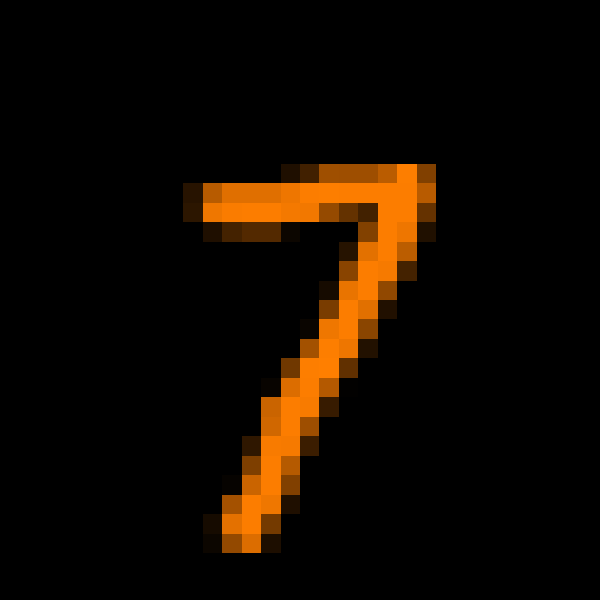

In [69]:
plot_digits(df_pixels.filter(pl.col("digit") == "7"))

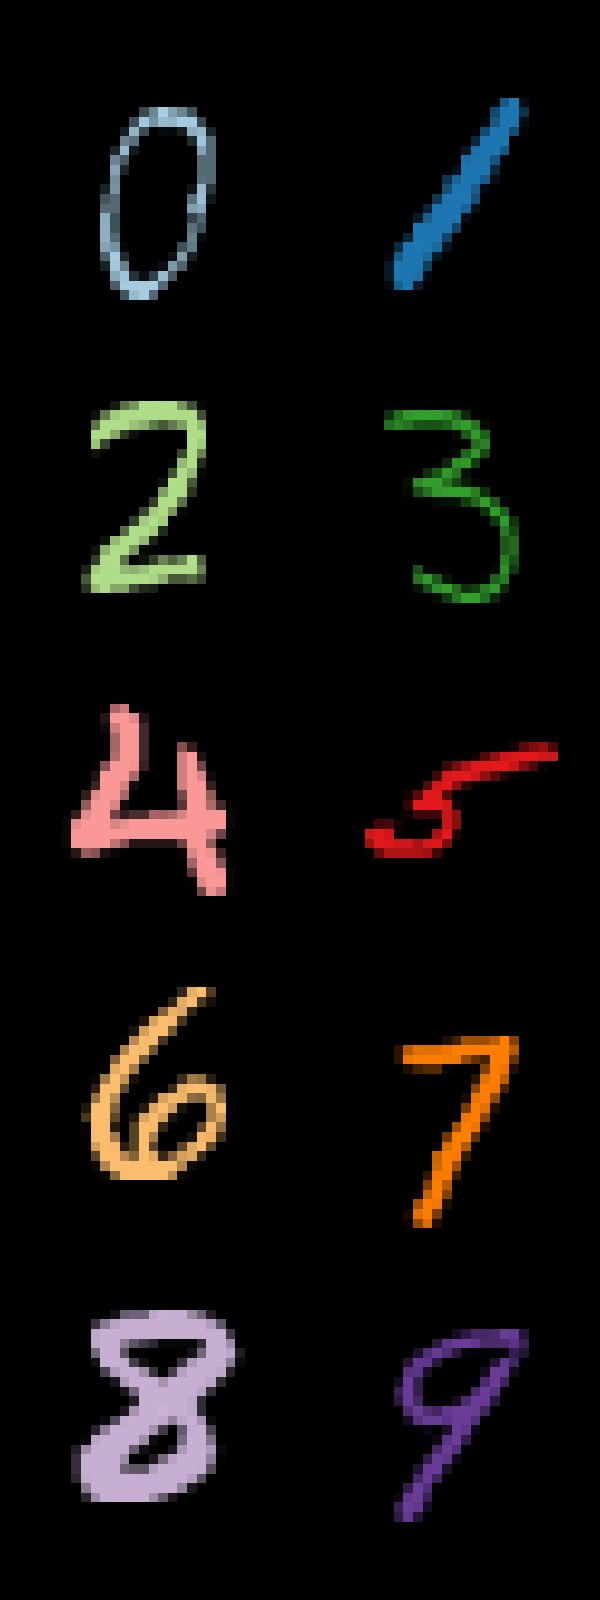

In [70]:
plot_digits(df_pixels, height=8)

## Plot embedding

In [136]:
df_epochs = pl.read_parquet("data/epochs.parquet")
df_epochs

index,x,y,digit,epoch
u32,f32,f32,cat,u16
0,0.481639,0.526492,"""5""",0
1,0.61237,0.573228,"""0""",0
2,0.42596,0.636468,"""4""",0
3,0.400917,0.414444,"""1""",0
4,0.41914,0.602288,"""9""",0
…,…,…,…,…
29995,0.382934,0.505783,"""8""",199
29996,0.36772,0.719987,"""9""",199
29997,0.826281,0.416917,"""6""",199


In [137]:
num_epochs = df_epochs.select(pl.col("epoch").max()).item() + 1
num_digits = df_epochs.select(pl.col("index").max()).item() + 1

In [138]:
def plot_embedding(df_, epoch, max_epochs, legend=True):
    df_ = (df_.filter(pl.col("epoch") == epoch))
    
    frame = (
        ggplot(df_, aes("x", "y", color="digit"))
        + geom_point(size=0.04, alpha=1)
        + annotate("segment", x=0, y=1.05, xend=epoch/max_epochs, yend=1.05, 
                  color="white", size=1)
        + guides(colour=guide_legend(override_aes={"size": 5, "alpha": 1}))
        + scale_color_brewer(type="qual", palette=3)
        + scale_x_continuous(limits=(0, 1), expand=(0, 0.001, 0, 0.001))
        + scale_y_continuous(limits=(0, 1.06), expand=(0, 0.01, 0, 0.01))
        + labs(title="MNIST data embedded into two dimensions by UMAP",
              subtitle="Each point is a handwritten digit")
        + theme_void(base_size=16, base_family="Futura")
        + theme(
           text=element_text(color="white"),
           plot_title=element_text(ha="left"),
           plot_caption=element_text(ha="left"),
           axis_title=element_blank(),
           axis_text=element_blank(),
           plot_margin=0.05,
           plot_background=element_rect(fill="black"),
           figure_size=(8, 8)
        )
    )

    if legend:
        frame += theme(
            legend_position=(1, 0),
            legend_direction='horizontal',
            legend_title=element_blank(),
        )
    else:
         frame += theme(legend_position="none")
    return frame

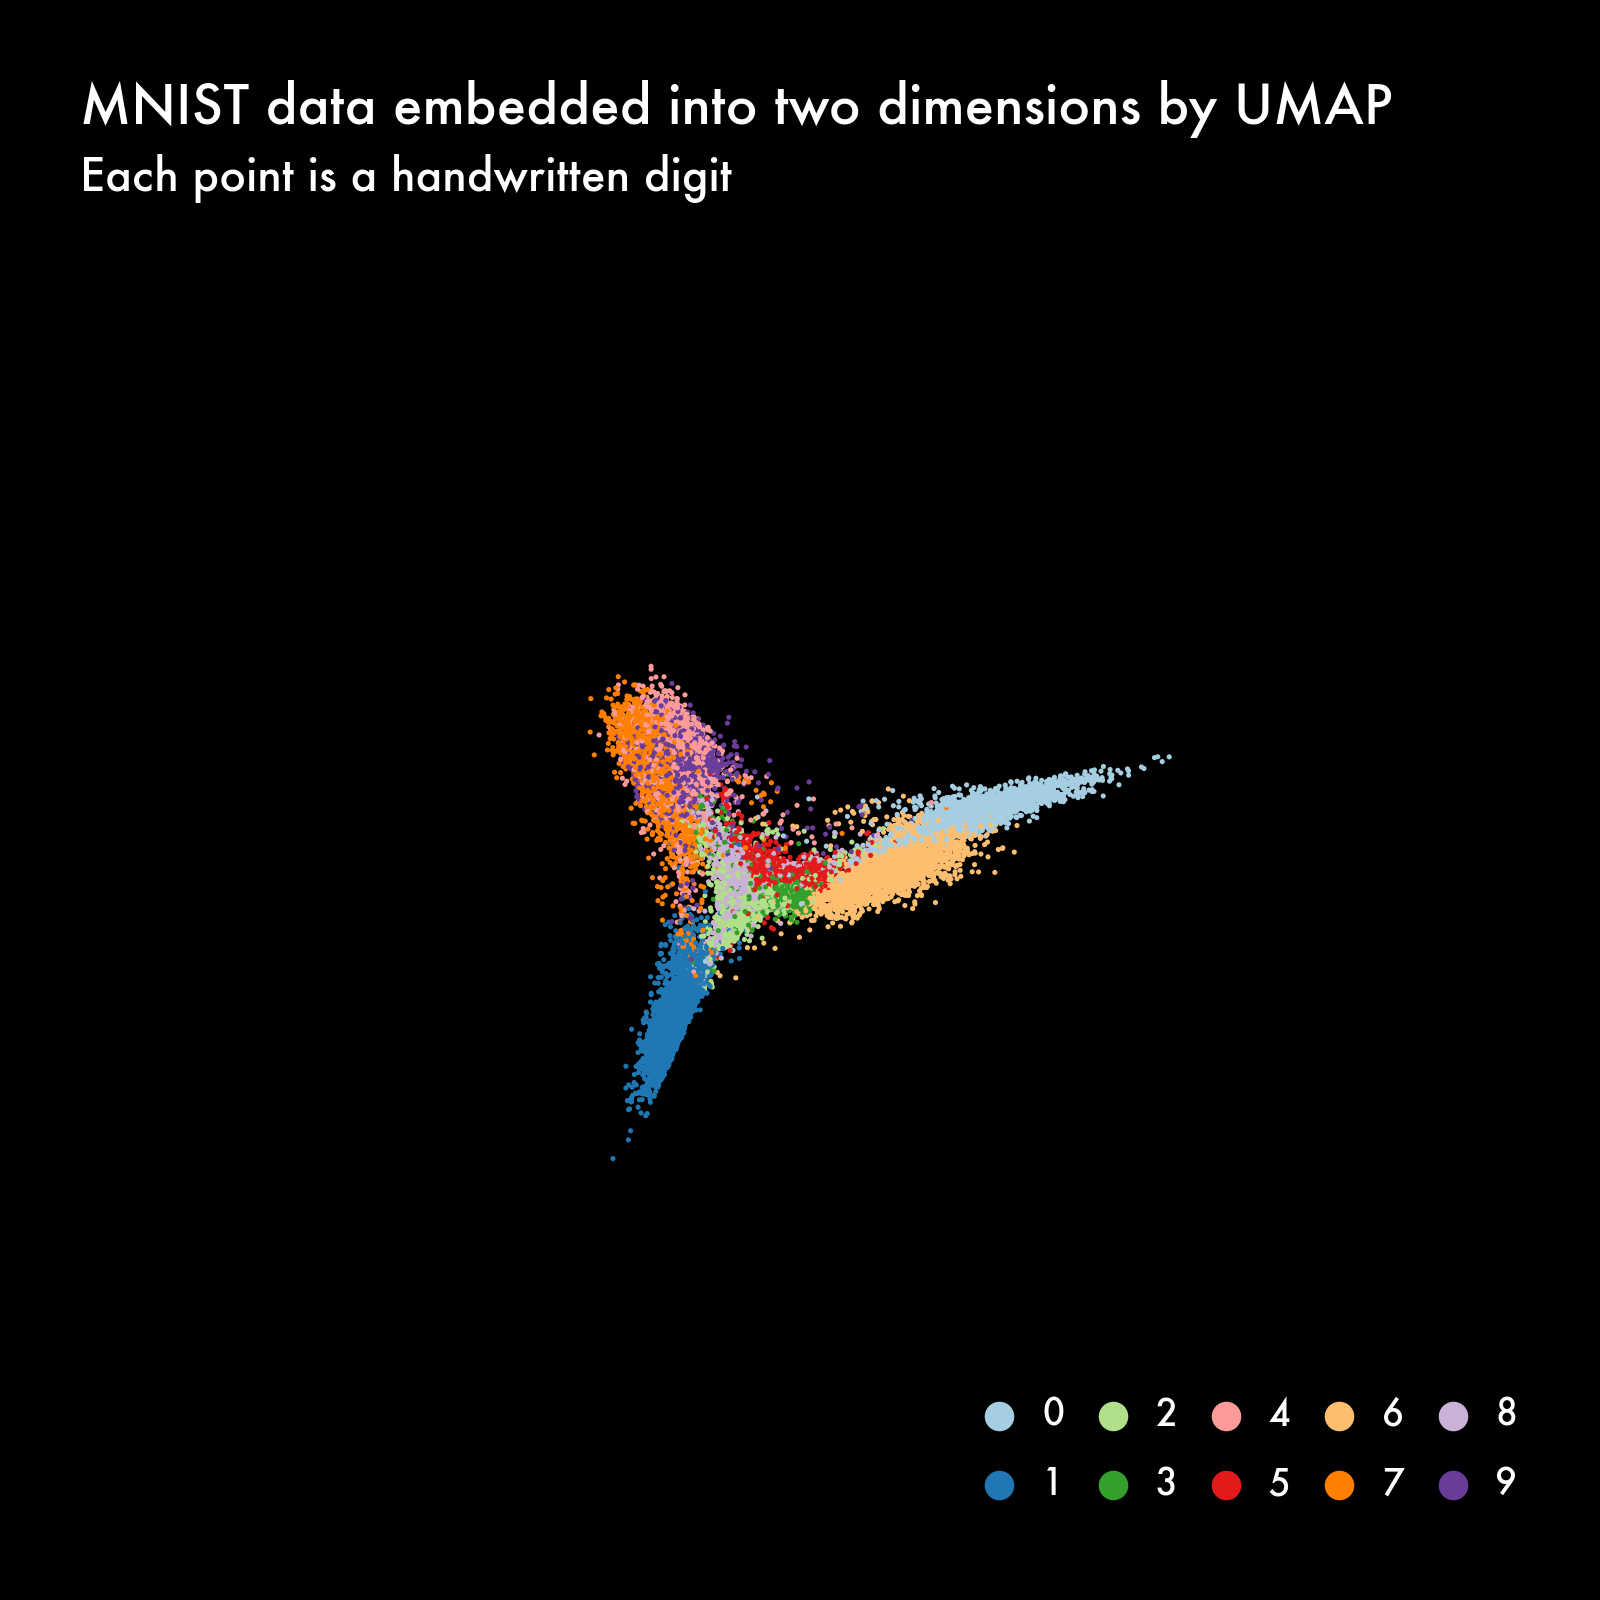

In [139]:
plot_embedding(df_epochs, 0, num_epochs)

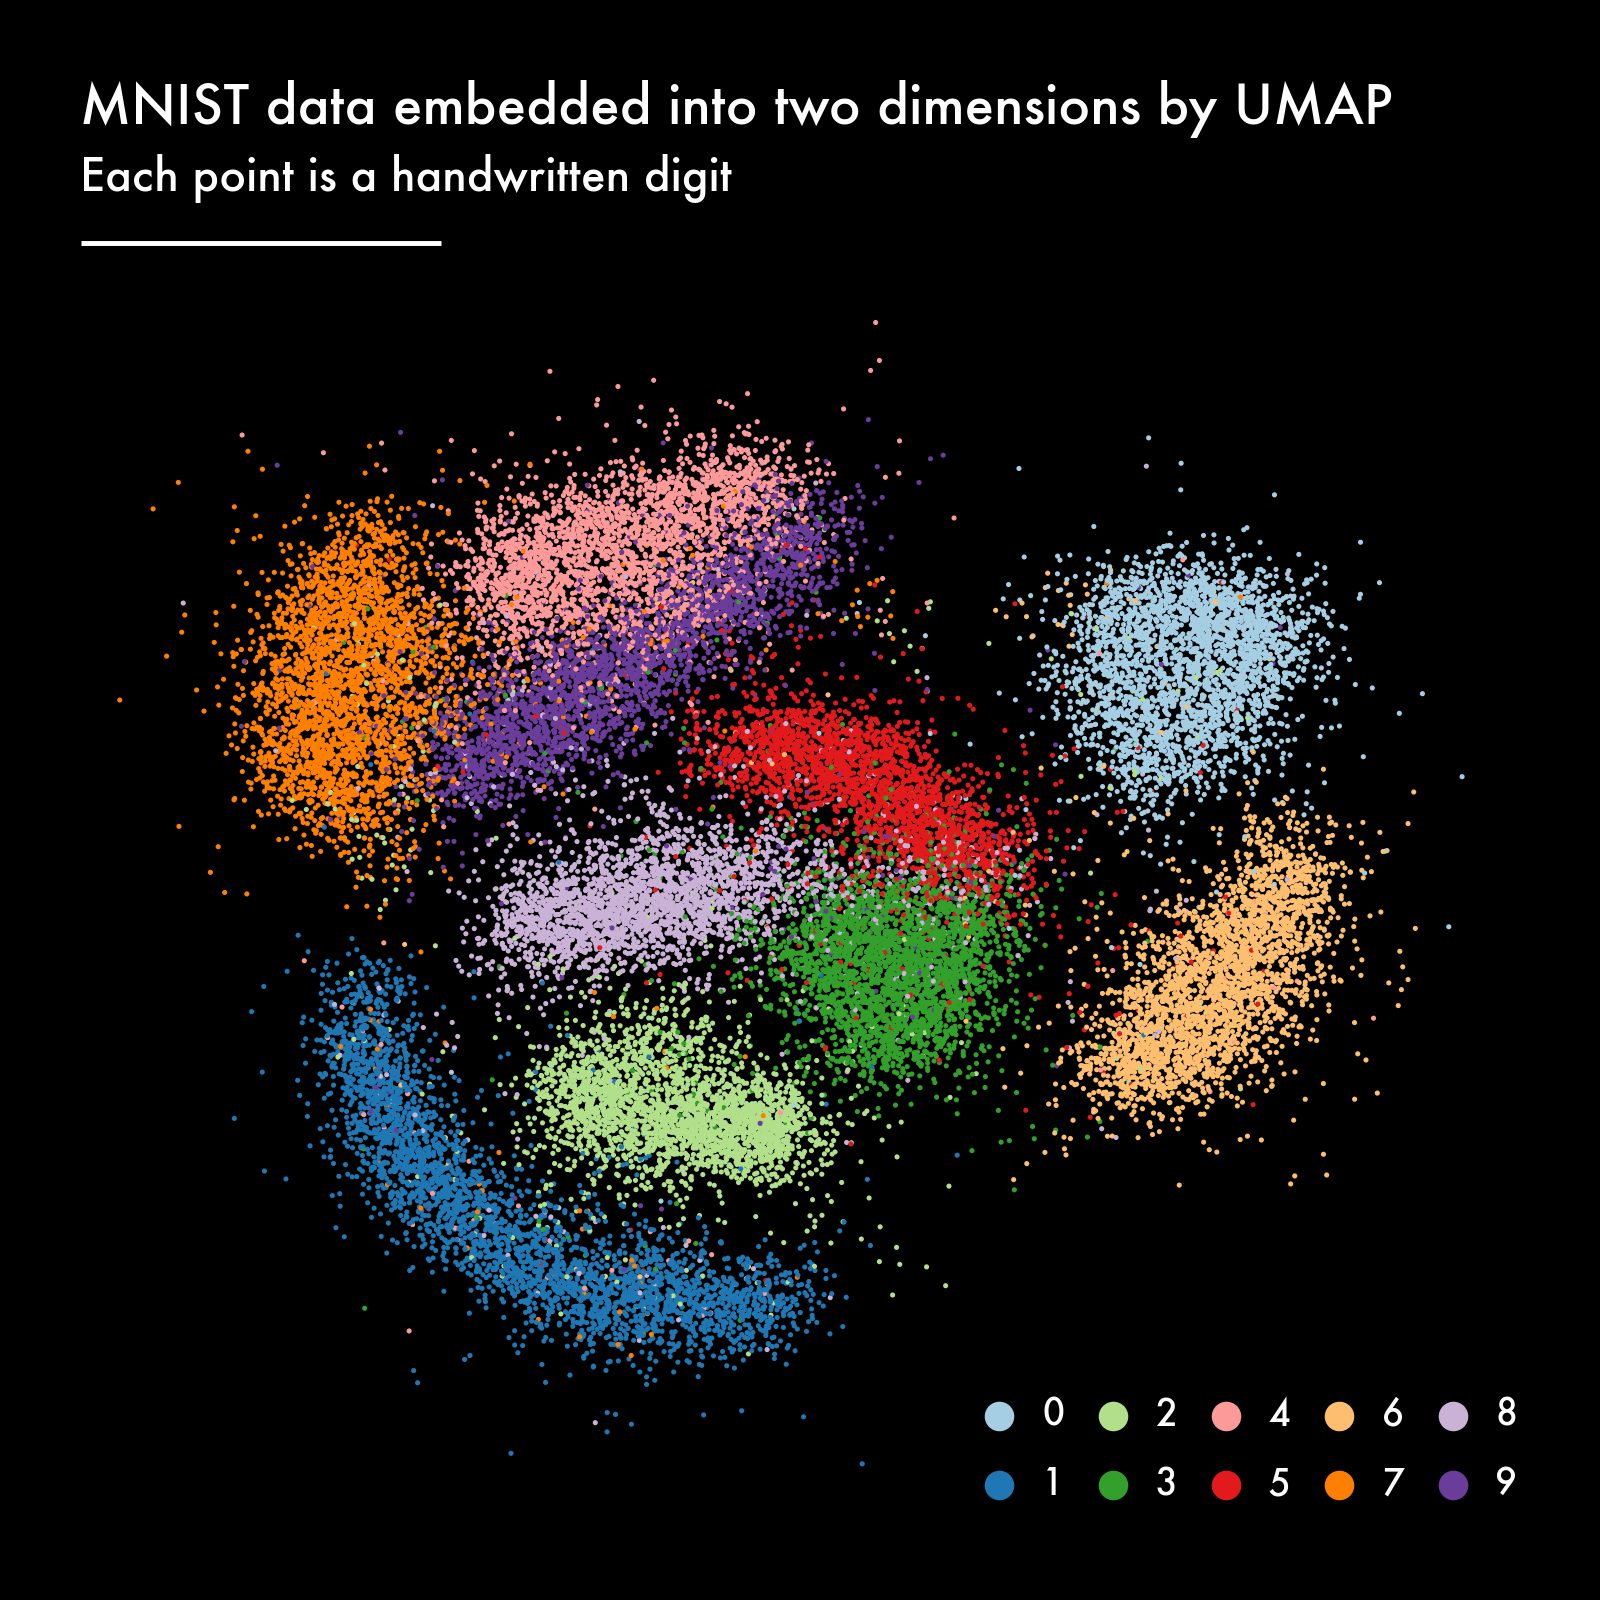

In [140]:
plot_embedding(df_epochs, num_epochs//4, num_epochs)

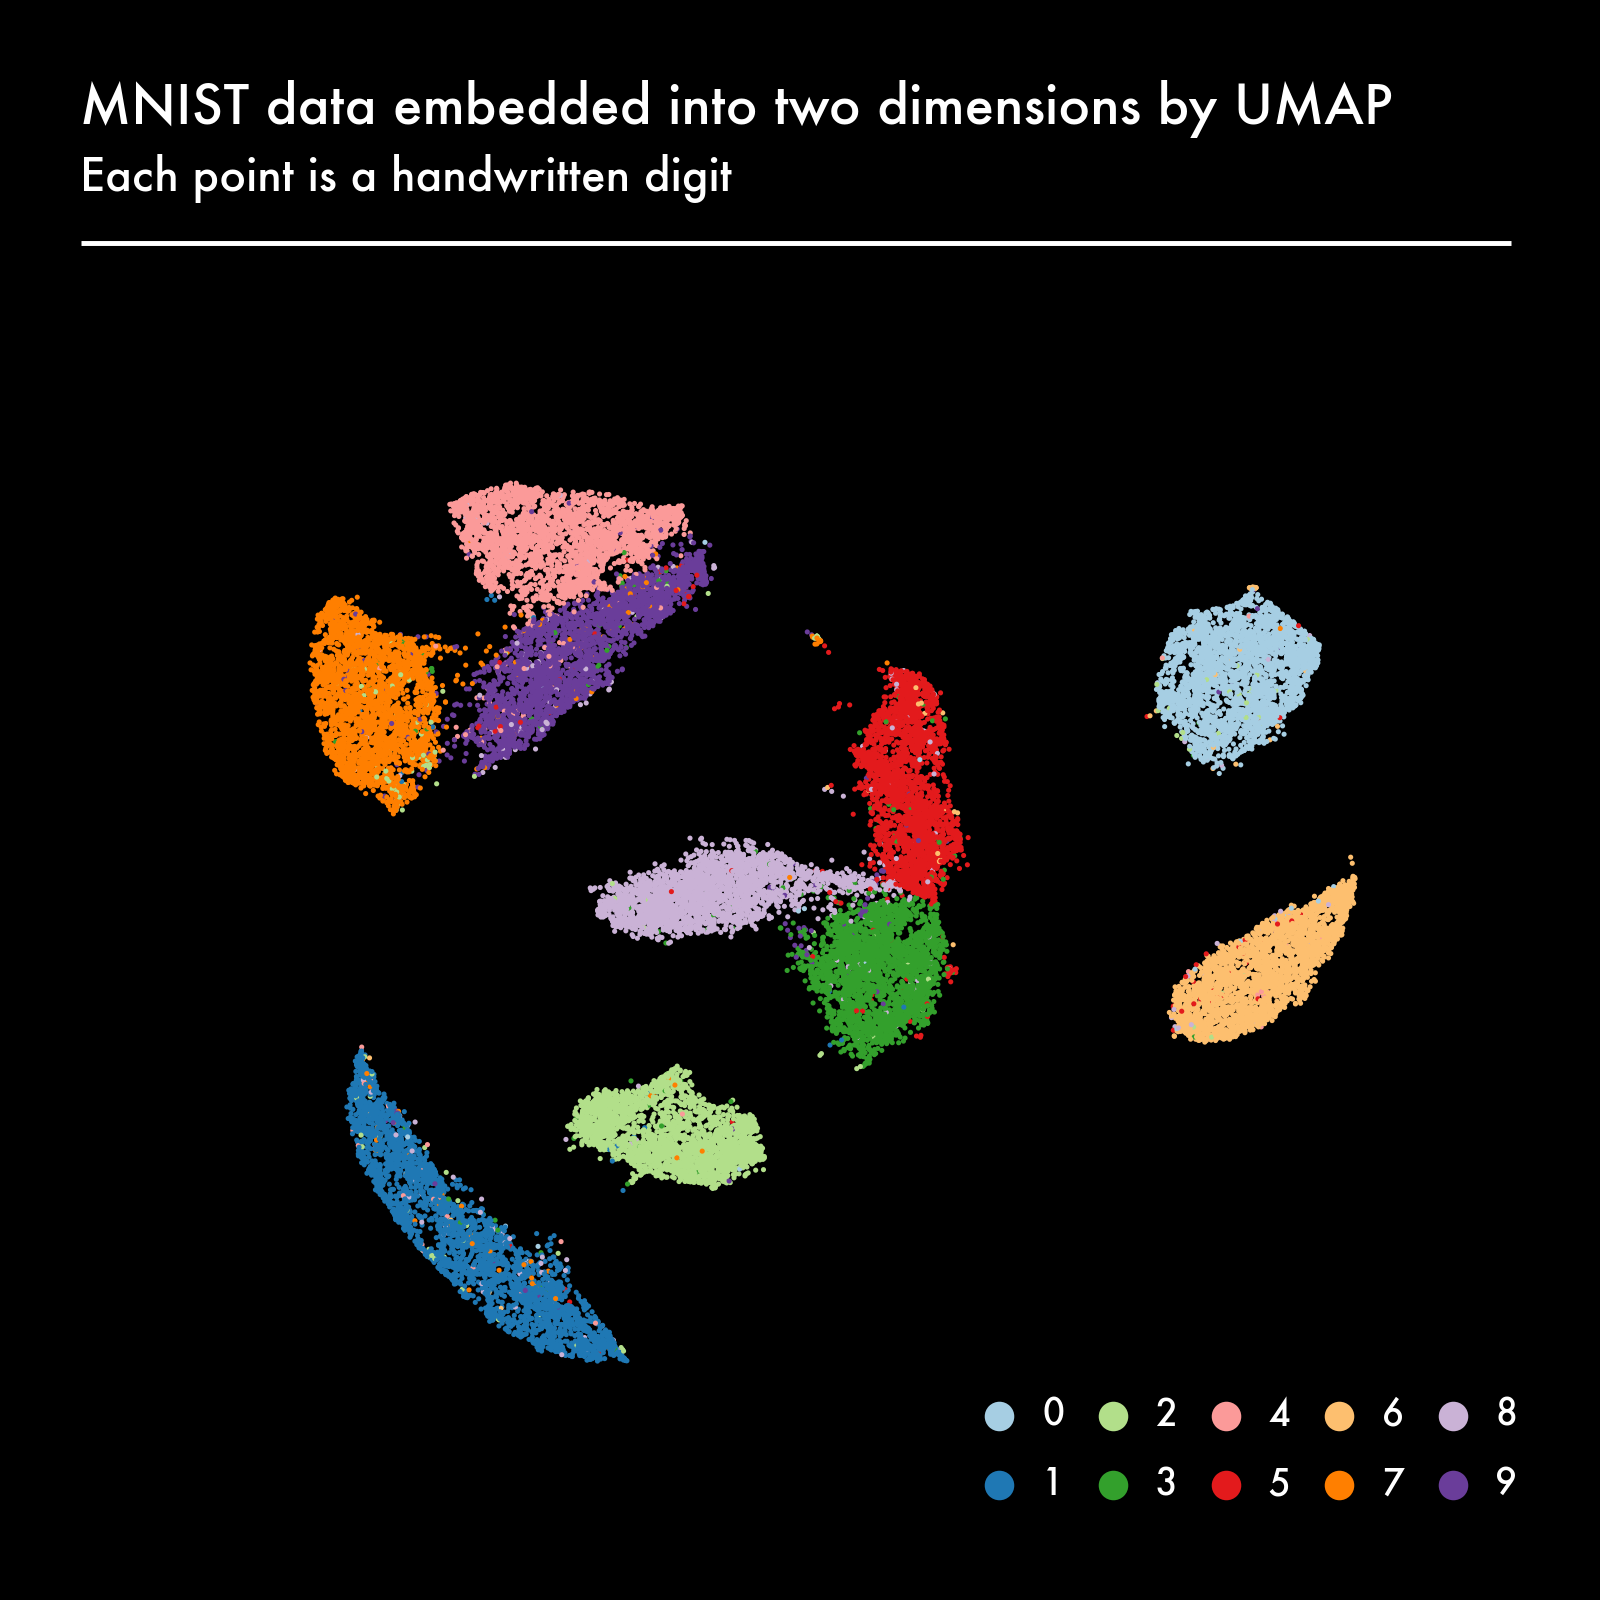

In [141]:
plot_embedding(df_epochs, num_epochs-1, num_epochs)

## Combine into one picture

In [142]:
plot_embedding(df_epochs, num_epochs-1, num_epochs, legend=False).save("images/embedding.png", verbose=False)
plot_digits(get_pixels(df_digits, seed=42), height=8).save("images/legend.png", verbose=False)

In [143]:
from PIL import Image

# Open the images
embedding_img = Image.open("images/embedding.png")
legend_img = Image.open("images/legend.png")

# Get the dimensions of the images
embedding_width, embedding_height = embedding_img.size
legend_width, legend_height = legend_img.size

# Create a new image with the combined width and the maximum height of the two images
combined_width = embedding_width + legend_width
combined_height = max(embedding_height, legend_height)
combined_img = Image.new("RGB", (combined_width, combined_height))

# Paste the images into the new image
combined_img.paste(embedding_img, (0, 0))
combined_img.paste(legend_img, (embedding_width, 0))

# Save the combined image
combined_img.save("images/combined.png")

![](images/combined.png)

## Animate

Need `ffmpeg`

In [144]:
for i in range(num_epochs):
    print(f"Frame {i}/{num_epochs-1}", end="\r")
    plot_embedding(df_epochs, i, num_epochs, legend=False).save(f"frames/embedding-{i:06}.png", verbose=False)
    plot_digits(get_pixels(df_digits), height=8).save(f"frames/legend-{i:06}.png", verbose=False)

In [160]:
%%bash
ffmpeg \
  -i frames/embedding-%06d.png \
  -i frames/legend-%06d.png \
  -filter_complex "[0:v][1:v]hstack=inputs=2" \
  -framerate 30 \
  -pix_fmt yuv420p \
  -vcodec libx264 \
  -crf 18 \
  -y \
  -loglevel error \
  movies/umap.mp4

https://github.com/jeroenjanssens/umap-animated/assets/1368256/3a967d88-02e7-4085-ae49-b85fe154b442